In [330]:
from aeon.classification.distance_based import KNeighborsTimeSeriesClassifier
from aeon.datasets import load_classification
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import balanced_accuracy_score
import itertools
import matplotlib.pyplot as plt
import numpy as np

# Kepler Light Curve Dataset

In [3]:
X_train_f, y_train_f = load_classification(name="KeplerLightCurves", split="train", return_metadata=False)
X_test_f, y_test_f = load_classification(name="KeplerLightCurves", split="test", return_metadata=False)

Load in the data...

In [209]:
X_train = X_train_f.squeeze(axis=1)
y_train = y_train_f.astype(int)
X_test = X_test_f.squeeze(axis=1)
y_test = y_test_f.astype(int)

X_train_window = X_train[:, :200]   
X_test_window = X_test[:, :200]

Extract the classes of interest

In [210]:
class_a_tr_idxs = np.argwhere(y_train == 3).flatten()
x_tr_class_a = X_train_window[class_a_tr_idxs, :]
class_b_tr_idxs = np.argwhere(y_train == 5).flatten()
x_tr_class_b = X_train_window[class_b_tr_idxs, :]
X_train_sub = np.vstack([x_tr_class_a, x_tr_class_b])
y_train_sub = np.concatenate([np.ones(len(class_a_tr_idxs), dtype=np.int8), 2*np.ones(len(class_b_tr_idxs), dtype=np.int8)])

In [211]:
class_a_te_idxs = np.argwhere(y_test == 3).flatten()
x_te_class_a = X_test_window[class_a_te_idxs, :]
class_b_te_idxs = np.argwhere(y_test == 5).flatten()
x_te_class_b = X_test_window[class_b_te_idxs, :]
X_test_sub = np.vstack([x_te_class_a, x_te_class_b])
y_test_sub = np.concatenate([np.ones(len(class_a_te_idxs), dtype=np.int8), 2*np.ones(len(class_b_te_idxs), dtype=np.int8)])

Check the shapes

In [212]:
print(X_train_sub.shape)
print(y_train_sub.shape)
print(X_test_sub.shape)
print(y_test_sub.shape)

(427, 200)
(427,)
(185, 200)
(185,)


Z-score the time-series

In [213]:
# rescale the data
zs = StandardScaler().fit(X_train_sub)
X_train_sub_zs = zs.transform(X_train_sub)  
X_test_sub_zs = zs.transform(X_test_sub)

Fit the 1NN-DTW Model

In [214]:
classifier = KNeighborsTimeSeriesClassifier(distance="dtw")
classifier.fit(X_train_sub_zs, y_train_sub)
sc = classifier.score(X_test_sub_zs, y_test_sub)

In [224]:
y_preds = classifier.predict(X_test_sub_zs)
bal_acc = balanced_accuracy_score(y_test_sub, y_preds)

In [225]:
print(f"Raw accuracy: {sc}")
print(f"Balanced accuracy: {bal_acc}")

Raw accuracy: 0.9135135135135135
Balanced accuracy: 0.8980037017451084


In [317]:
confmat = confusion_matrix(y_test_sub, y_preds, normalize='true')
confmat

array([[0.94354839, 0.05645161],
       [0.14754098, 0.85245902]])

In [315]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='1NN-DTW Confusion Matrix, Z-Scored, T = 200',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[0.94354839 0.05645161]
 [0.14754098 0.85245902]]


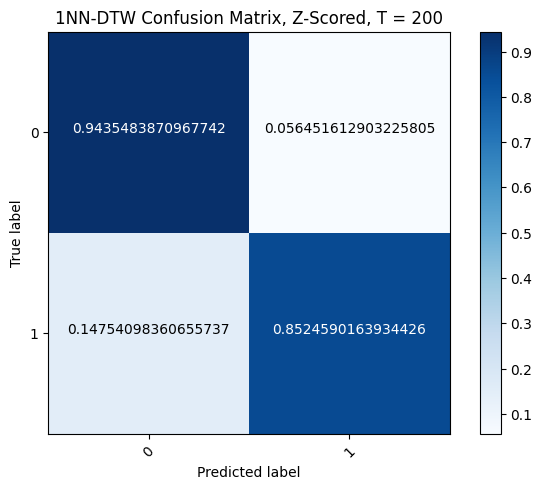

In [318]:
plot_confusion_matrix(confmat, [0, 1])

In [281]:
incorrect_idxs = np.argwhere(y_preds != y_test_sub).flatten()

In [287]:
len(incorrect_idxs)

16

In [280]:
X_test_sub.shape

(185, 200)

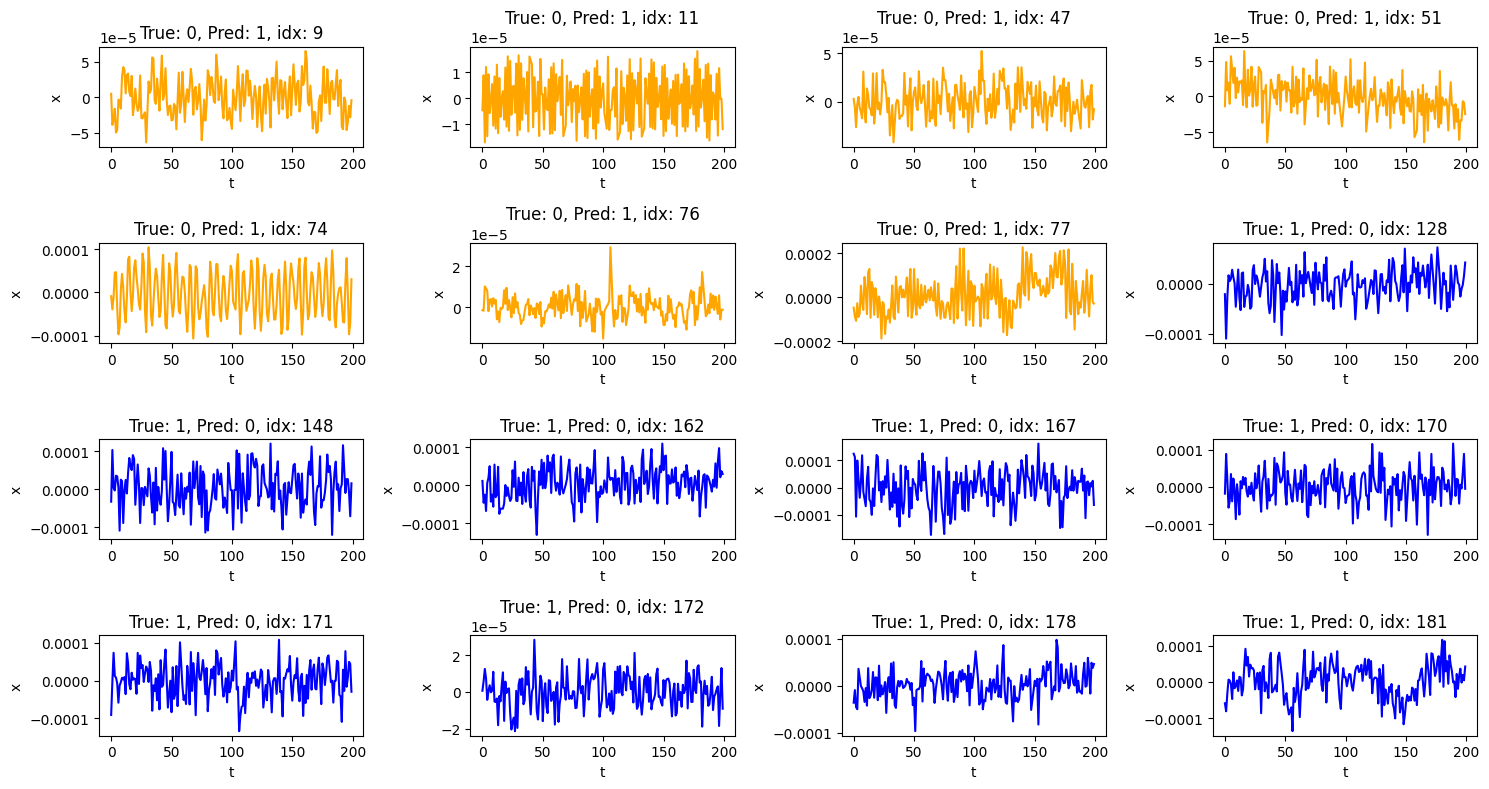

In [309]:
fig, axes = plt.subplots(4, 4, figsize=(15, 8))
for (i, ax) in enumerate(axes.ravel()):
    if y_test_sub[incorrect_idxs[i]] == 1:
        plot_colour = 'orange'
    else:
        plot_colour = 'blue'
    ax.plot(X_test_sub[incorrect_idxs[i]], c=plot_colour)
    ax.set_title(f"True: {y_test_sub[incorrect_idxs[i]]-1}, Pred: {y_preds[incorrect_idxs[i]]-1}, idx: {incorrect_idxs[i]}") # subtract 1 to match julia indexing
    ax.set_xlabel("t")
    ax.set_ylabel("x")
fig.tight_layout()

In [329]:
print(f"precision: {precision_score(y_test_sub, y_preds)}")
print(f"F1: {f1_score(y_test_sub, y_preds)}")
print(f"Recall: {recall_score(y_test_sub, y_preds)}")

precision: 0.9285714285714286
F1: 0.936
Recall: 0.9435483870967742


# MinMax Only

Scaling to the [-1, 1] interval.

In [335]:
# rescale the data
mm = MinMaxScaler(feature_range=(-1, 1)).fit(X_train_sub)
X_train_sub_mm = mm.transform(X_train_sub)  
X_test_sub_mm = mm.transform(X_test_sub)

In [337]:
classifier_mm = KNeighborsTimeSeriesClassifier(distance="dtw")
classifier_mm.fit(X_train_sub_mm, y_train_sub)
sc_mm = classifier.score(X_test_sub_mm, y_test_sub)

In [339]:
sc_mm

0.6702702702702703

In [338]:
y_preds_mm = classifier_mm.predict(X_test_sub_mm)
bal_acc_mm = balanced_accuracy_score(y_test_sub, y_preds_mm)

In [340]:
bal_acc_mm

0.7338709677419355

In [346]:
print(f"precision: {precision_score(y_test_sub, y_preds_mm)}")
print(f"F1: {f1_score(y_test_sub, y_preds_mm)}")
print(f"Recall: {recall_score(y_test_sub, y_preds_mm)}")

precision: 1.0
F1: 0.6373626373626373
Recall: 0.46774193548387094


Confusion matrix, without normalization
[[58 66]
 [ 0 61]]


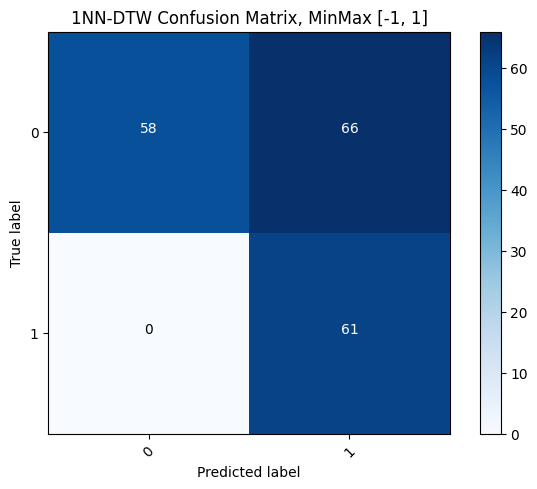

In [345]:
confmat_mm = confusion_matrix(y_test_sub, y_preds_mm)
plot_confusion_matrix(confmat_mm, [0, 1], title="1NN-DTW Confusion Matrix, MinMax [-1, 1]")

# RobustSigmoid Only

In [383]:
from sklearn.base import BaseEstimator, TransformerMixin

In [398]:
class ScaledRobustSigmoid(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()
    def fit(self, X, y=None):
        self.medianX = np.median(X)
        self.iqrX = np.quantile(X, 0.75, method='hazen') - np.quantile(X, 0.25, method='hazen')
        return self
    def transform(self, X, y=None, range=(-1, 1)):
        xhat = 1/(1 + np.exp(-(X-self.medianX)/(self.iqrX/1.35)))
        # rescale
        xhat = MinMaxScaler(feature_range=range).fit_transform(xhat)
        return xhat
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

In [406]:
srs = ScaledRobustSigmoid().fit(X_train_sub)
X_train_sub_srs = srs.transform(X_train_sub)  
X_test_sub_srs = srs.transform(X_test_sub)

In [407]:
classifier_srs = KNeighborsTimeSeriesClassifier(distance="dtw")
classifier_srs.fit(X_train_sub_srs, y_train_sub)
sc_srs = classifier.score(X_test_sub_srs, y_test_sub)

In [408]:
sc_srs

0.8324324324324325

In [409]:
y_preds_srs = classifier_srs.predict(X_test_sub_srs)
bal_acc_srs = balanced_accuracy_score(y_test_sub, y_preds_srs)
bal_acc_srs

0.8445267054468535

In [410]:
print(f"precision: {precision_score(y_test_sub, y_preds_srs)}")
print(f"F1: {f1_score(y_test_sub, y_preds_srs)}")
print(f"Recall: {recall_score(y_test_sub, y_preds_srs)}")

precision: 0.8759124087591241
F1: 0.9195402298850575
Recall: 0.967741935483871


Confusion matrix, without normalization
[[0.96774194 0.03225806]
 [0.27868852 0.72131148]]


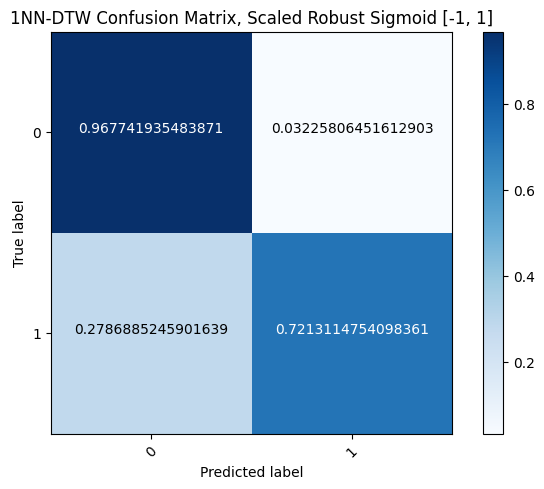

In [413]:
confmat_srs = confusion_matrix(y_test_sub, y_preds_srs, normalize='true')
plot_confusion_matrix(confmat_srs, [0, 1], title="1NN-DTW Confusion Matrix, Scaled Robust Sigmoid [-1, 1]")